In [1]:
from __future__ import print_function
import torch
import numpy as np
import sinkhorn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import train
import argparse
import timeit
import util
from linear_run import *
import itertools

one = torch.FloatTensor([1])

In [2]:
def average(v, stepsize=1e-3):
    """
    Average time series on intervals of size stepsize
    """
    v = v[v[:,1].argsort()] 
    h = np.histogram(v[:, 1], bins=np.arange(v[0,1], v[-1, 1], stepsize))
    h_ind = np.where(h[0])
    ind = np.cumsum(h[0][h_ind])
    ind = np.concatenate((np.zeros(1), ind)).astype(int)
    h = h[1][h_ind]
    z = [np.mean(v[ind[i]:ind[i+1], 0]) for i in range(len(h))]
    return h, z

In [3]:
K = 100
dim = 20
lamb = 1.
expstart = 1
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)
nexp = 1
cost = sinkhorn._linear_cost
losses = {}

# Sinkhorn

In [4]:
sinkiterrange = [3, 5, 7, 10]
sinklrrange = np.geomspace(10, 100, 5)
sinkmaxiter = 5000

In [5]:
losses['sinkhorn'] = {}
for s in itertools.product(sinkiterrange, sinklrrange):
    sinkiter, sinklr = s[0], s[1]
    losses['sinkhorn'][(sinkiter, sinklr)] = []
    for exp in range(expstart, expstart+nexp):
        l = np.load('experiments/softmax/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn/losses.npy'.format(exp, lamb, K, dim, sinkiter, sinklr))
        t = np.load('experiments/softmax/{0}_lamb{1}_k{2}_dim{3}_sinkiter{4}_lr{5}_sinkhorn/time.npy'.format(exp, lamb, K, dim, sinkiter, sinklr))
        losses['sinkhorn'][(sinkiter, sinklr)] += zip(l, t)

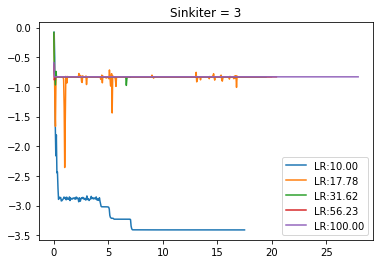

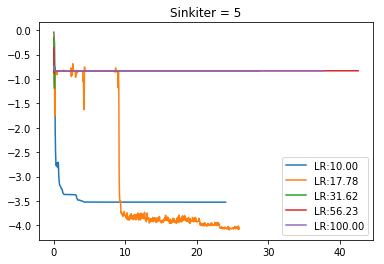

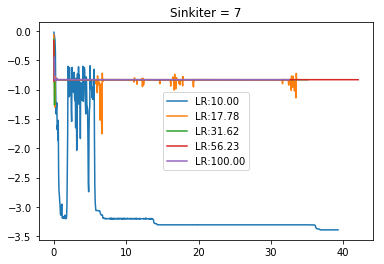

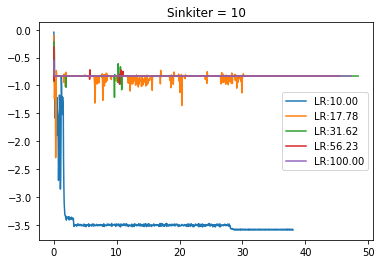

In [6]:
for sinkiter in sinkiterrange:
    plt.figure()
    for sinklr in sinklrrange:
        h, z = average(np.array(losses['sinkhorn'][(sinkiter, sinklr)]), stepsize=5e-2)
        plt.plot(h, z, label='LR:{0:.2f}'.format(sinklr))
    plt.legend()
    plt.title('Sinkiter = {}'.format(sinkiter))
    plt.show()

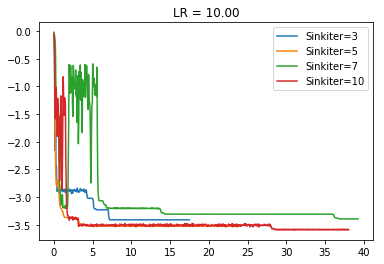

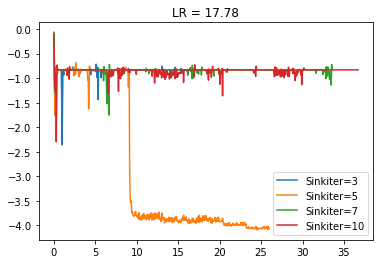

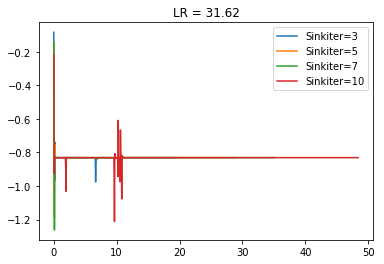

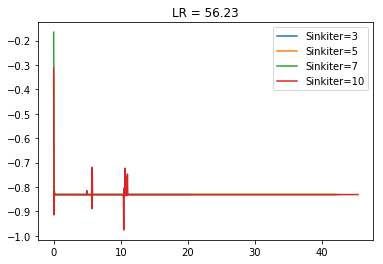

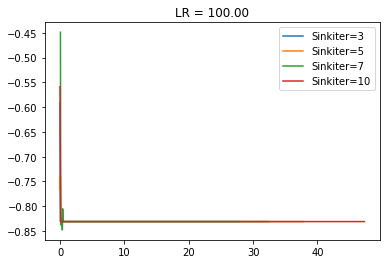

In [7]:
for sinklr in sinklrrange:
    plt.figure()
    for sinkiter in sinkiterrange:
        h, z = average(np.array(losses['sinkhorn'][(sinkiter, sinklr)]), stepsize=5e-2)
        plt.plot(h, z, label='Sinkiter={}'.format(sinkiter))
    plt.legend()
    plt.title('LR = {0:.2f}'.format(sinklr))
    plt.show()

# Descent

In [8]:
descentlrrange = np.geomspace(10, 1000, 10)
descentmaxiter = 50000

In [9]:
losses['descent'] = {}

for descentlr in descentlrrange:
    losses['descent'][descentlr] = []
    for exp in range(expstart, expstart+nexp):
        l = np.load('experiments/softmax/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent/losses.npy'.format(exp, lamb, K, dim, descentlr))
        t = np.load('experiments/softmax/{0}_lamb{1}_k{2}_dim{3}_lr{4}_descent/time.npy'.format(exp, lamb, K, dim, descentlr))
        losses['descent'][descentlr] += zip(l,t)

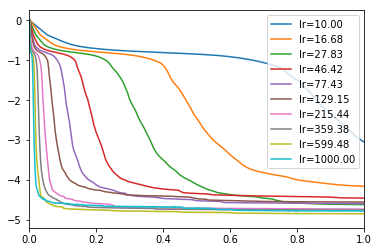

In [10]:
plt.figure()
for descentlr in descentlrrange:
    h, z = average(np.array(losses['descent'][descentlr]), stepsize=1e-4)
    plt.plot(h,z, label='lr={0:.2f}'.format(descentlr))
plt.legend()
plt.xlim(0, 1)
plt.show()

# DC

In [11]:
dclrrange = np.geomspace(0.0000001, 0.00001, 10)
dcdualiterrange = [3, 5, 10, 20]
dcmaxiter = 1000

In [13]:
losses['dc'] = {}
for s in itertools.product(dcdualiterrange, dclrrange):
    dcdualiter, dclr = s[0], s[1]
    losses['dc'][(dcdualiter, dclr)] = []
    for exp in range(expstart, expstart+nexp):
        l = np.load('experiments/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc/losses.npy'.format(exp, lamb, K, dim, dcdualiter, dclr))
        t = np.load('experiments/{0}_lamb{1}_k{2}_dim{3}_dualiter{4}_lr{5}_dc/time.npy'.format(exp, lamb, K, dim, dcdualiter, dclr))
        losses['dc'][(dcdualiter, dclr)] += zip(l, t)    

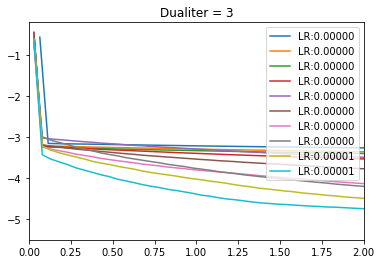

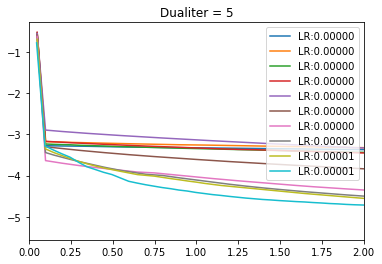

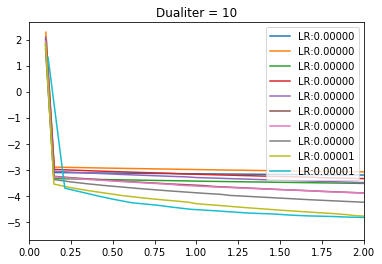

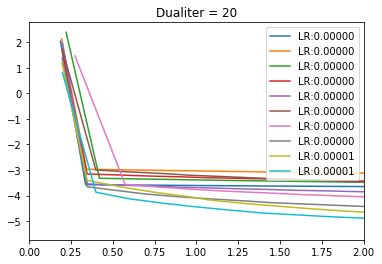

In [14]:
for dcdualiter in dcdualiterrange:
    plt.figure()
    for dclr in dclrrange:
        h, z = average(np.array(losses['dc'][(dcdualiter, dclr)]), stepsize=5e-2)
        plt.plot(h, z, label='LR:{0:.5f}'.format(dclr))
    plt.legend()
    plt.xlim(0, 2)
    plt.title('Dualiter = {}'.format(dcdualiter))
    plt.show()

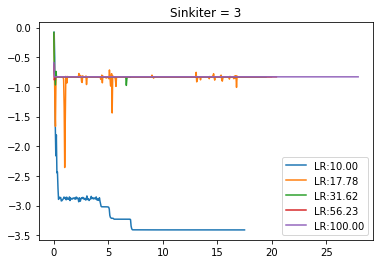

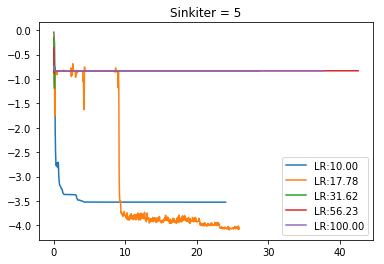

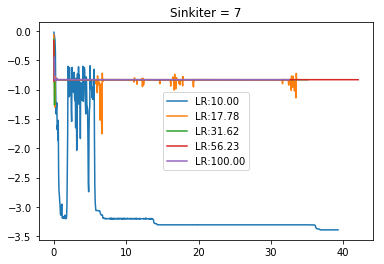

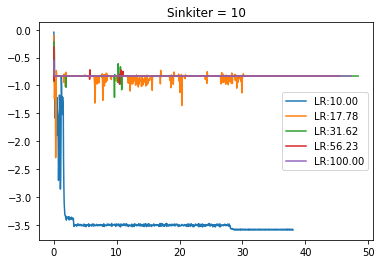

In [15]:
for sinkiter in sinkiterrange:
    plt.figure()
    for sinklr in sinklrrange:
        h, z = average(np.array(losses['dc'][(dcdualiter, dclr)]), stepsize=5e-2)
        plt.plot(h, z, label='LR:{0:.2f}'.format(sinklr))
    plt.legend()
    plt.title('Sinkiter = {}'.format(sinkiter))
    plt.show()

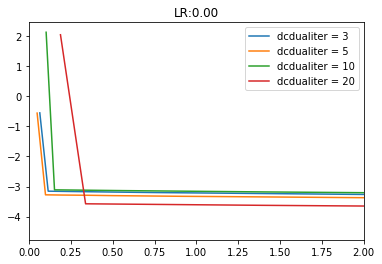

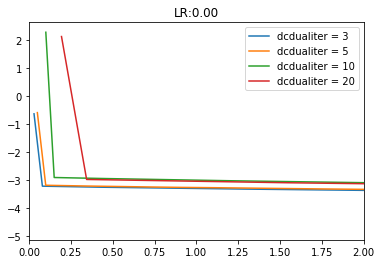

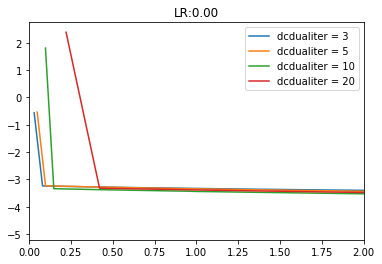

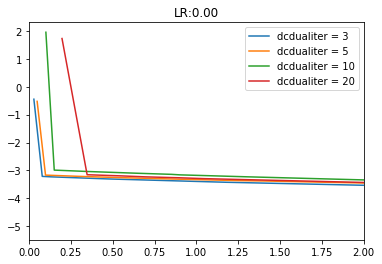

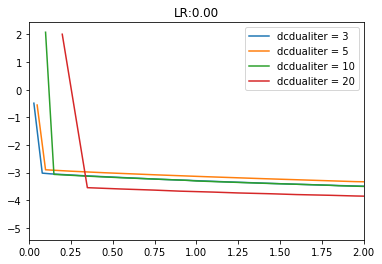

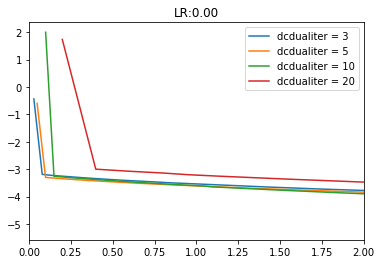

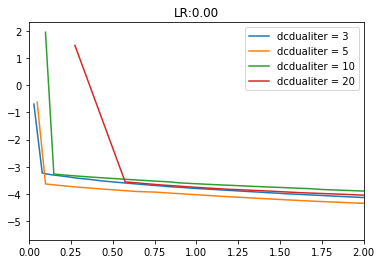

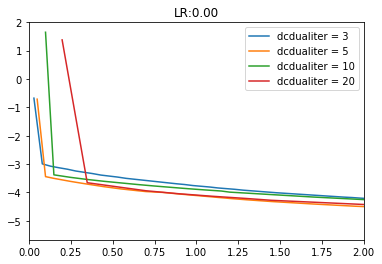

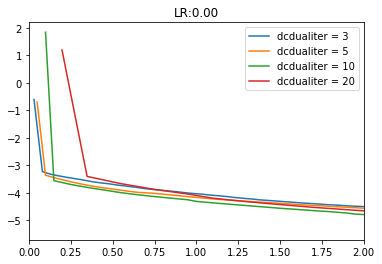

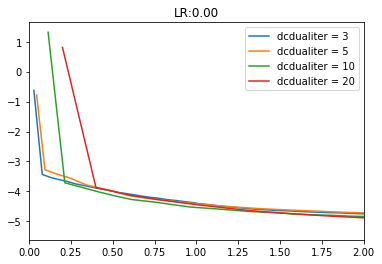

In [16]:
for dclr in dclrrange:
    plt.figure()
    for dcdualiter in dcdualiterrange:
        h, z = average(np.array(losses['dc'][(dcdualiter, dclr)]), stepsize=5e-2)
        plt.plot(h, z, label='dcdualiter = {}'.format(dcdualiter))
    plt.legend()
    plt.xlim(0, 2)
    plt.title('LR:{0:.2f}'.format(100*dclr))
    plt.show()